### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import joblib

Setting Global Random seed

In [3]:
np.random.seed(42)

## Loading and preparing Data

In [4]:
df = pd.read_csv("train_genetic_disorders_cleaned.csv")

In [5]:
print(df['genetic_disorder'].value_counts(normalize=True))

genetic_disorder
Mitochondrial genetic inheritance disorders     0.512168
Single-gene inheritance diseases                0.383149
Multifactorial genetic inheritance disorders    0.104682
Name: proportion, dtype: float64


### Feature Engineering

In [6]:
df['age_group'] = pd.cut(df['patient_age'], bins=[0, 2, 12, 18], labels=['infant', 'child', 'adolescent'])

df['genetic_risk'] = (df['maternal_gene_defect'] == 'Yes').astype(int) + (df['paternal_gene_defect'] == 'Yes').astype(int)

def classify_vital_status(resp_rate, heart_rate):
    if resp_rate == "Tachypnea" and heart_rate == "Tachycardia":
        return "Severely Elevated"
    elif resp_rate == "Tachypnea" or heart_rate == "Tachycardia":
        return "Elevated"
    else:
        return "Normal"

df["vital_status"] = df.apply(lambda row: classify_vital_status(row["respiratory_rate"], row["heart_rate"]), axis=1)

def classify_birth_complications(asphyxia, autopsy, defects):
    if asphyxia == "Yes" or autopsy == "Yes" or defects in ["Singular", "Multiple"]:
        return 1
    return 0

df["birth_complications"] = df.apply(lambda row: classify_birth_complications(
    row["birth_asphyxia"], row["birth_defect_autopsy"], row["birth_defects"]), axis=1)

def classify_maternal_risk(illness, radiation, substance):
    if illness == "Yes" or radiation == "Yes" or substance == "Yes":
        return 1
    return 0

df["maternal_risk_factors"] = df.apply(lambda row: classify_maternal_risk(
    row["maternal_illness_history"], row["radiation_exposure_history"], row["substance_abuse_history"]), axis=1)

def classify_pregnancy_history(anomalies, abortions):
    if anomalies == "Yes" or abortions == "Yes":
        return 1
    return 0

df["pregnancy_history"] = df.apply(lambda row: classify_pregnancy_history(
    row["previous_pregnancy_anomalies"], row["previous_abortions"]), axis=1)

In [7]:
col_to_drop = [
    "patient_age",
    # "respiratory_rate", "heart_rate",
    # "birth_asphyxia", "birth_defect_autopsy", "birth_defects",
    # "maternal_illness_history", "radiation_exposure_history", "substance_abuse_history",
    # "maternal_gene_defect", "paternal_gene_defect",
    # "maternal_gene", "paternal_gene",
    "birth_place"
]

df = df.drop(columns=col_to_drop)


In [8]:
df.head()

,maternal_gene_defect,paternal_gene_defect,maternal_gene,paternal_gene,RBC_count,status,respiratory_rate,heart_rate,follow_up,gender,...,assisted_conception,previous_pregnancy_anomalies,previous_abortions,birth_defects,white_blood_cell_count,blood_test_result,genetic_disorder,disorder_subclass,symptom_total,age_group
0,Yes,No,Yes,No,4.760603,Alive,Normal (30-60),Normal,High,Missing,...,No,Yes,2.0,Multiple,9.857562,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,5,infant
1,Yes,No,Yes,No,5.073391,Alive,Normal (30-60),Tachycardia,Low,Male,...,Yes,No,4.0,Multiple,8.605348,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,5,child
2,Yes,Yes,Yes,Yes,5.067562,Deceased,Normal (30-60),Tachycardia,Low,Female,...,Yes,No,0.0,Singular,3.494528,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,child
3,Yes,No,Yes,Yes,5.133352,Deceased,Tachypnea,Normal,Low,Male,...,No,Yes,3.0,Multiple,8.614972,normal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,child
4,Yes,Yes,Yes,Yes,4.805143,Alive,Normal (30-60),Tachycardia,High,Female,...,No,No,4.0,Singular,3.756223,slightly abnormal,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,4,adolescent


In [9]:
numerical_cols = df.select_dtypes(include=["number"]).columns
# df['age_group'] = df['age_group'].astype('object')
categorical_cols = df.select_dtypes(include=["object"]).columns

## Label Encoding

In [10]:
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [11]:
df.head()

,maternal_gene_defect,paternal_gene_defect,maternal_gene,paternal_gene,RBC_count,status,respiratory_rate,heart_rate,follow_up,gender,...,assisted_conception,previous_pregnancy_anomalies,previous_abortions,birth_defects,white_blood_cell_count,blood_test_result,genetic_disorder,disorder_subclass,symptom_total,age_group
0,1,0,1,0,4.760603,0,0,0,0,2,...,0,1,2.0,0,9.857562,3,0,5,5,infant
1,1,0,1,0,5.073391,0,0,1,1,1,...,1,0,4.0,0,8.605348,3,0,5,5,child
2,1,1,1,1,5.067562,1,0,1,1,0,...,1,0,0.0,1,3.494528,3,0,5,4,child
3,1,0,1,1,5.133352,1,1,0,1,1,...,0,1,3.0,0,8.614972,2,0,5,4,child
4,1,1,1,1,4.805143,0,0,1,0,0,...,0,0,4.0,1,3.756223,3,0,5,4,adolescent


## One Hot Encoding

In [12]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = onehot_encoder.fit_transform(df[['age_group']])
encoded_df = pd.DataFrame(encoded_array, columns=onehot_encoder.get_feature_names_out(['age_group']))
df= pd.concat([df.drop(columns=['age_group']).reset_index(drop=True), encoded_df], axis=1)

## OverSampling using SMOTE

<Axes: ylabel='count'>

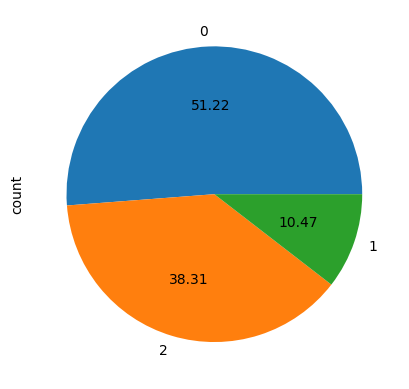

In [13]:
X = df.drop(['genetic_disorder','disorder_subclass'], axis=1)
y = df['genetic_disorder']
y.value_counts().plot.pie(autopct='%.2f')

<Axes: ylabel='count'>

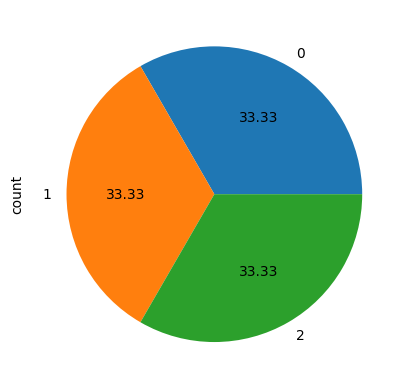

In [14]:
sm = SMOTE(random_state=42)
X_res,y_res = sm.fit_resample(X,y)
y_res.value_counts().plot.pie(autopct='%.2f')

In [15]:
corr_matrix = df.corr()
print("Correlation Matrix:\n", corr_matrix)

Correlation Matrix:
                               maternal_gene_defect  paternal_gene_defect  \
maternal_gene_defect                      1.000000              0.010528   
paternal_gene_defect                      0.010528              1.000000   
maternal_gene                             0.104436              0.030122   
paternal_gene                            -0.015026              0.093615   
RBC_count                                -0.004256             -0.009536   
status                                    0.004293              0.012827   
respiratory_rate                         -0.005129             -0.006944   
heart_rate                                0.004641              0.023990   
follow_up                                -0.006013              0.006671   
gender                                    0.003763             -0.006902   
birth_asphyxia                            0.005651             -0.006866   
birth_defect_autopsy                      0.007297              0.0

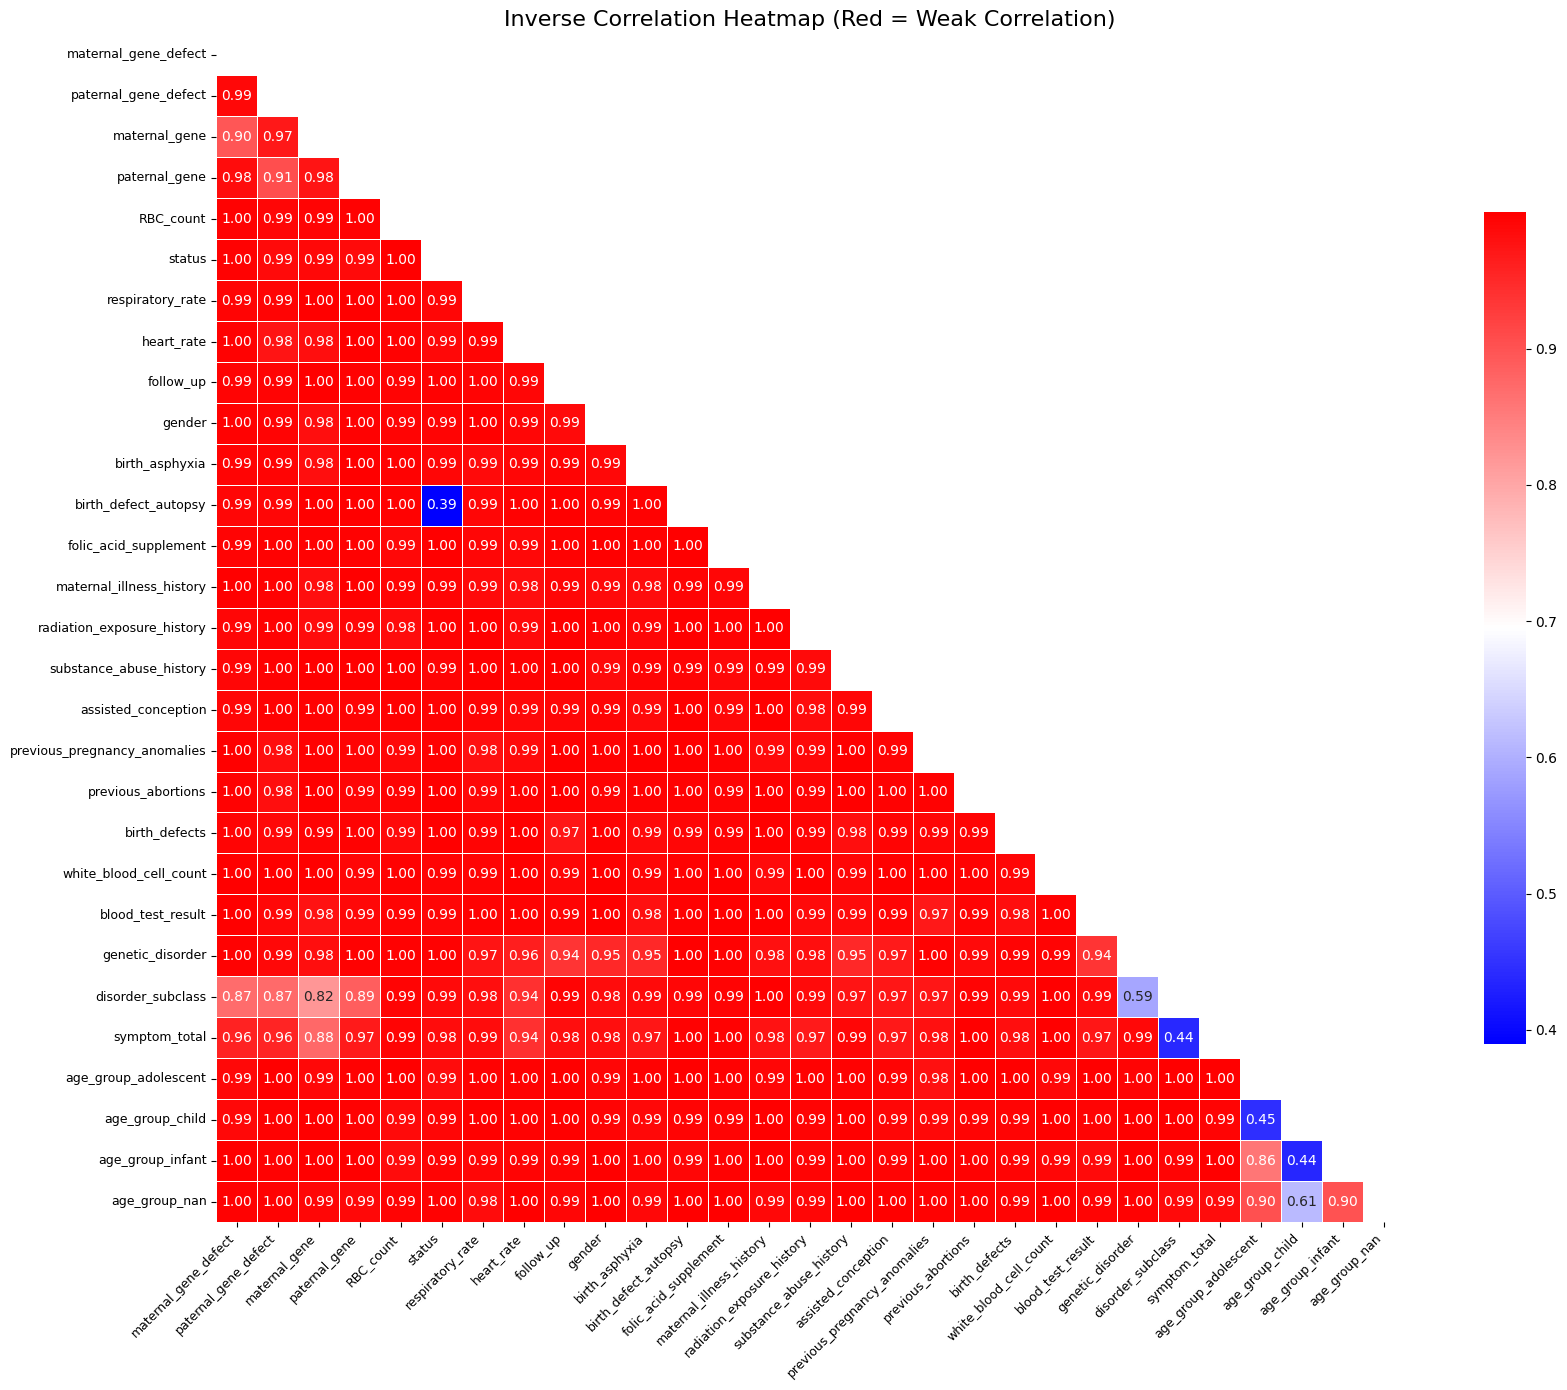

In [20]:
plt.figure(figsize=(18, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]
custom_cmap = LinearSegmentedColormap.from_list("inverse_corr", colors, N=256)

transformed = 1 - abs(corr_matrix)

sns.heatmap(
    transformed,
    mask=mask,
    cmap=custom_cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.7},
    annot=True,
    fmt=".2f"
)

plt.title("Inverse Correlation Heatmap (Red = Weak Correlation)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    stratify=y_res,
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 23284
Test samples: 5822


In [16]:
print(X_train.shape,X_test.shape)

(23284, 27) (5822, 27)


## Applying PCA

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=18) 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## XGB Model 

In [18]:
from xgboost import XGBClassifier
import xgboost as xgb

xgb_classifier = XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.7,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    random_state=42,
    reg_alpha=10,    
    reg_lambda=20,   
)

xgb_classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=9, ...)

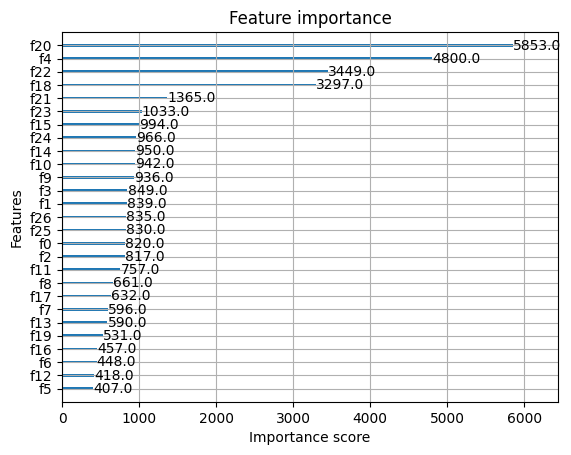

In [19]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_classifier)
plt.show()


In [20]:
y_pred = xgb_classifier.predict(X_test)

xgb_train_accuracy = accuracy_score(y_train, xgb_classifier.predict(X_train))
xgb_test_accuracy = accuracy_score(y_test, y_pred)

In [21]:
print(f"Train Accuracy: {xgb_train_accuracy:.4f}")
print(f"Test Accuracy: {xgb_test_accuracy:.4f}")

Train Accuracy: 0.7689
Test Accuracy: 0.7284


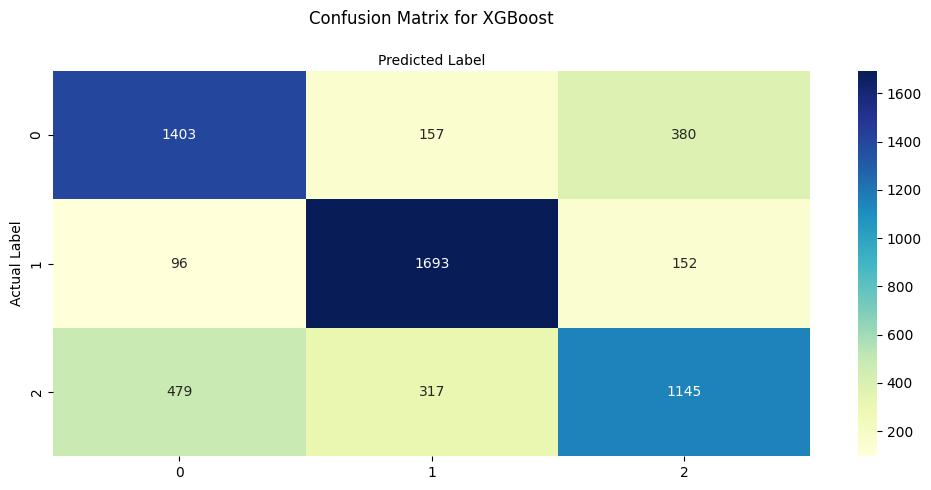

In [22]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')

plt.title(f'Confusion Matrix for XGBoost', y=1.1)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.show()

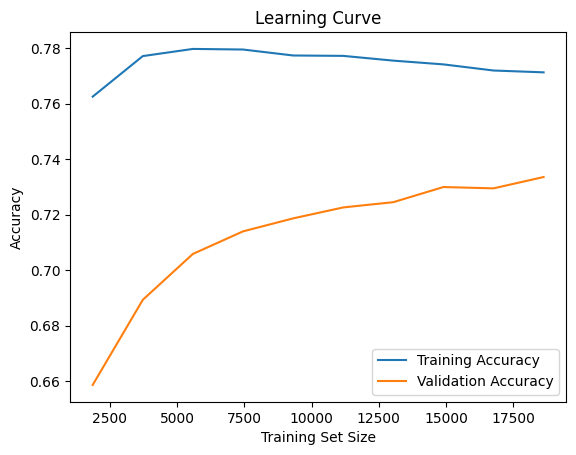

In [23]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    xgb_classifier, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.legend()
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()


# Exporting Model

In [25]:
joblib.dump(scaler, "scaler.pkl")
# joblib.dump(pca, "pca.pkl")
joblib.dump(label_encoder, "label_encoders.pkl")
joblib.dump(onehot_encoder, "one_hot_encoder.pkl")
joblib.dump(xgb_classifier, "xgb_model.pkl")

['xgb_model.pkl']

## Trying Other models

In [26]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(
    solver='lbfgs', 
    max_iter=500, 
    random_state=42
)

In [27]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [28]:
y_pred = log_reg.predict(X_test)

lg_train_accuracy = accuracy_score(y_train, log_reg.predict(X_train))
lg_test_accuracy = accuracy_score(y_test, y_pred)

In [29]:
print(f"Train Accuracy: {lg_train_accuracy:.4f}")
print(f"Test Accuracy: {lg_test_accuracy:.4f}")

Train Accuracy: 0.5956
Test Accuracy: 0.5915


In [30]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

In [31]:
svm_classifier.fit(X_train, y_train)

SVC(random_state=42)

In [32]:
y_pred = svm_classifier.predict(X_test)

svm_train_accuracy = accuracy_score(y_train, svm_classifier.predict(X_train))
svm_test_accuracy = accuracy_score(y_test, y_pred)

In [33]:
print(f"Train Accuracy: {svm_train_accuracy:.4f}")
print(f"Test Accuracy: {svm_test_accuracy:.4f}")

Train Accuracy: 0.7833
Test Accuracy: 0.6994


In [34]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

In [35]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       oob_score=True, random_state=42)

In [36]:
y_pred = rf_classifier.predict(X_test)

rf_train_accuracy = accuracy_score(y_train, rf_classifier.predict(X_train))
rf_test_accuracy = accuracy_score(y_test, y_pred)

In [37]:
print(f"Train Accuracy: {rf_train_accuracy:.4f}")
print(f"Test Accuracy: {rf_test_accuracy:.4f}")

Train Accuracy: 0.6678
Test Accuracy: 0.6554


In [38]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

catboost_classifier = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=3,
    loss_function='MultiClass',
    random_state=42,
    verbose=0
)

catboost_classifier.fit(X_train, y_train)

In [39]:
y_pred_cat = catboost_classifier.predict(X_test)

cat_train_accuracy = accuracy_score(y_train, catboost_classifier.predict(X_train))
cat_test_accuracy = accuracy_score(y_test, y_pred_cat)

print(f"CatBoost Train Accuracy: {cat_train_accuracy:.4f}")
print(f"CatBoost Test Accuracy: {cat_test_accuracy:.4f}")

CatBoost Train Accuracy: 0.7280
CatBoost Test Accuracy: 0.7120


In [40]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=3,       
    max_features='sqrt',
    random_state=42
)

hybrid_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model)],
    voting='soft',       
    flatten_transform=True
)

In [41]:
hybrid_model.fit(X_train, y_train)

C:\Users\mohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:18:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_con...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=500,
                                                     random_state=42))],
                 voting='soft')

In [42]:
y_pred_hybrid = hybrid_model.predict(X_test)

hybrid_train_acc = accuracy_score(y_train, hybrid_model.predict(X_train))
hybrid_test_acc = accuracy_score(y_test, y_pred_hybrid)

print(f"Hybrid Model Train Accuracy: {hybrid_train_acc:.4f}")
print(f"Hybrid Model Test Accuracy: {hybrid_test_acc:.4f}")

Hybrid Model Train Accuracy: 0.7542
Hybrid Model Test Accuracy: 0.7200


joblib.dump(hybrid_model, "hybrid_model.pkl")

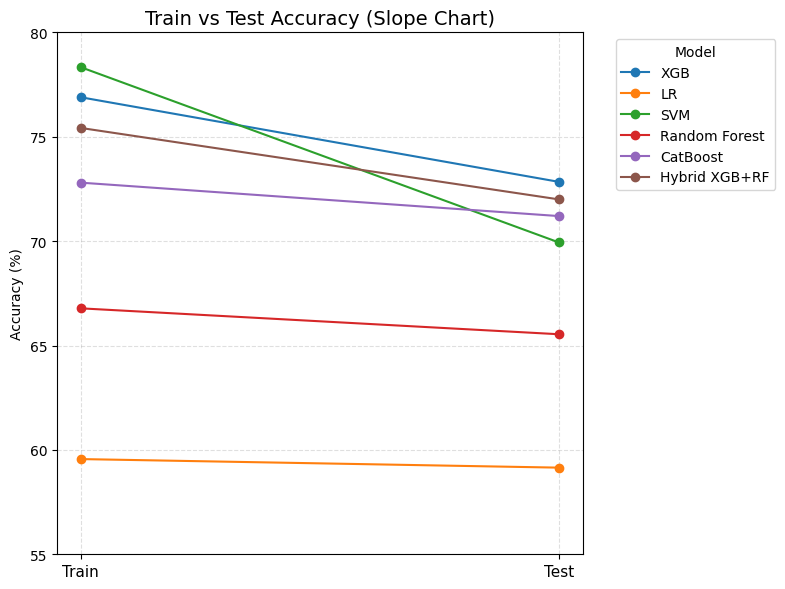

In [43]:
models = ['XGB', 'LR', 'SVM', 'Random Forest', 'CatBoost', 'Hybrid XGB+RF']
train_acc = [76.89, 59.56, 78.33, 66.78, 72.80, 75.42]
test_acc = [72.84, 59.15, 69.94, 65.54, 71.20, 72]

plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.plot(['Train', 'Test'], [train_acc[i], test_acc[i]], marker='o', label=models[i])

plt.title('Train vs Test Accuracy (Slope Chart)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(55, 80)
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(['Train', 'Test'], fontsize=11)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
